## Chapter 14: Simple Linear Regression

### The Model
Investigating relationship between a user’s # of friends + amount of time spent on the site each day. Assume having more friends causes people to spend more time on the site, rather than an alternative explanation (Ch 5)

VP of Engagement asks you to build a model describing this relationship. Since you
found a pretty strong linear relationship, a natural place to start = a linear model.
In particular, you hypothesize that there are constants, alpha + beta such that `y_i = B*x_i + alpha + eps_i` where `y_i` = # of minutes user *i* spends on site daily, `x_i` = # of friends user *i* has, and `eps_i` = (hopefully small) irreducible error term, representing the fact that there're other factors not accounted for by this simple model.

Assuming we’ve determined such an alpha + beta, we make predictions simply with:

In [1]:
def predict(alpha,beta,x_i):
    return beta*x_i + alpha

How do we choose alpha and beta? Any choice of alpha and beta gives a predicted output for each input `x_i`, and since we know the actual output `y_i` we can compute error for each pair:

In [2]:
def residual(alpha,beta,x_i,y_i):
    """Error from predicting y_i with beta*x_i + alpha"""
    return y_i - predict(alpha,beta,x_i) # - (beta*x_i + alpha)

What we’d *really* like to know = **total error over the entire data set**. But we don’t want to just add the errors (too high + too low predictions may cancel), so instead add up squared errors:

In [3]:
def sse(alpha,beta,x,y):
    return sum(residual(alpha,beta,x_i,y_i)**2 for
              x_i, y_i in zip(x,y))

The **least squares solution** = choose alpha + beta that minimize `sse`. Using calculus (or tedious algebra), the error-minimizing alpha + beta are given by:

In [4]:
## SETUP
from __future__ import division # error for mean() without
def mean(x):
    return sum(x) / len(x)

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def de_mean(x):
    """translate x by subtracting its mean (so the result has mean 0)"""
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def variance(x):
    """assumes x has at least two elements"""
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(x):
    import math
    return math.sqrt(variance(x))

def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n - 1)

def correlation(x, y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x, y) / stdev_x / stdev_y

def least_squares(x,y):
    """Given training data (x,y), find least-squares values 
    of alpha and beta"""
    beta = correlation(x,y)*(standard_deviation(y)/standard_deviation(x))
    alpha = mean(y) - beta*mean(x)
    return alpha,beta

The choice of alpha simply says = when we see the average value of the independent variable `x`, predict average value of dependent variable `y`. The choice of beta means that when the input value increases by `standard_deviation(x)`, prediction increases by `correlation(x, y)*standard_deviation(y)`. 

In the case when x + y are *perfectly correlated*, a 1 SD increase in `x` results in a 1-SD-of-y increase in the prediction. When they’re perfectly *anticorrelated*, the increase in `x` results in a decrease in the prediction. And when correlation = 0, beta = zero, which means that changes in x don’t affect the prediction at all.

It’s easy to apply this to the outlierless data from Chapter 5:

In [5]:
num_friends = [100,49,41,40,25,21,21,19,19,18,18,16,15,15,15,15,14,14,13,13,13,13,12,12,11,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
daily_minutes = [1,68.77,51.25,52.08,38.36,44.54,57.13,51.4,41.42,31.22,34.76,54.01,38.79,47.59,49.1,27.66,41.03,36.73,48.65,28.12,46.62,35.57,32.98,35,26.07,23.77,39.73,40.57,31.65,31.21,36.32,20.45,21.93,26.02,27.34,23.49,46.94,30.5,33.8,24.23,21.4,27.94,32.24,40.57,25.07,19.42,22.39,18.42,46.96,23.72,26.41,26.97,36.76,40.32,35.02,29.47,30.2,31,38.11,38.18,36.31,21.03,30.86,36.07,28.66,29.08,37.28,15.28,24.17,22.31,30.17,25.53,19.85,35.37,44.6,17.23,13.47,26.33,35.02,32.09,24.81,19.33,28.77,24.26,31.98,25.73,24.86,16.28,34.51,15.23,39.72,40.8,26.06,35.76,34.76,16.13,44.04,18.03,19.65,32.62,35.59,39.43,14.18,35.24,40.13,41.82,35.45,36.07,43.67,24.61,20.9,21.9,18.79,27.61,27.21,26.61,29.77,20.59,27.53,13.82,33.2,25,33.1,36.65,18.63,14.87,22.2,36.81,25.53,24.62,26.25,18.21,28.08,19.42,29.79,32.8,35.99,28.32,27.79,35.88,29.06,36.28,14.1,36.63,37.49,26.9,18.58,38.48,24.48,18.95,33.55,14.24,29.04,32.51,25.63,22.22,19,32.73,15.16,13.9,27.2,32.01,29.27,33,13.74,20.42,27.32,18.23,35.35,28.48,9.08,24.62,20.12,35.26,19.92,31.02,16.49,12.16,30.7,31.22,34.65,13.13,27.51,33.2,31.57,14.1,33.42,17.44,10.12,24.42,9.82,23.39,30.93,15.03,21.67,31.09,33.29,22.61,26.89,23.48,8.38,27.81,32.35,23.84]


outlier = num_friends.index(100) # index of outlier

num_friends_good = [x for i, x in enumerate(num_friends)
                    if i != outlier]

daily_minutes_good = [x for i, x in enumerate(daily_minutes)
                      if i != outlier]

alpha,beta = least_squares(num_friends_good,daily_minutes_good)
print("alpha: ",alpha,"  beta: ",beta)

alpha:  22.94755241346903   beta:  0.9038659456058649


Model says we expect a user w/ `n` friends to spend `22.95 + 0.903n` min on the site each day. That is, we predict a user w/ no friends would still spend about 23 min a
day on the site + for each additional friend, we expect a user to spend almost 1 min. more on the site each day.

Plot the prediction line to get a sense of how well the model fits the observed data.


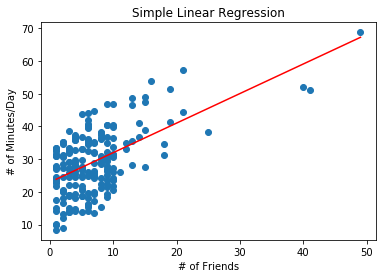

In [6]:
%matplotlib inline

from matplotlib import pyplot as plt

predictions = []

for friends in num_friends_good:
    #print(friends*beta)
    predictions.append(friends*beta + alpha)

plt.scatter(num_friends_good, daily_minutes_good)
plt.plot(num_friends_good, predictions, c = "r")
plt.title("Simple Linear Regression")
plt.xlabel("# of Friends")
plt.ylabel("# of Minutes/Day")
plt.show()

Of course, we need a better way to figure out how well we’ve fit the data than staring at
the graph. A common measure = **coefficient of determination, or R-squared, or R2**, which = the fraction of the *total* variation in the dependent variable/outcome that is captured/explained by the model:

In [7]:
def tss(y):
    """Total Sum of Squares variation of y_i's from the mean"""
    return sum(v**2 for v in de_mean(y))

def r2(alpha,beta,x,y):
    """Fraction of variation in y capture by model, which equals
    1 - fraction of variation in y NOT capture by model"""
    return 1.0 - (sse(alpha,beta,x,y) / tss(y))

r2(alpha,beta,num_friends_good,daily_minutes_good)

0.3291078377836305

We chose alpha + beta that minimized the sum of the squared *prediction* errors. 1 linear model we *could've* chosen = “always predict mean(y)” (corresponding to alpha = mean(y) + beta = 0), whose SSE exactly = its TSS, which means an R2 = 0, which indicates a model
that (obviously, in this case) performs no better than just predicting the mean (**baseline model**)

Clearly, least squares model must be at *least as good as that one*, which means SSE is *at most* = TSS, which means that the R2 must be *at least* = 0, *and* the SSE *must be* *at least* 0, which means R2 can be *at most* 1.

The higher the R2, the better a model fits the data. Here `R2 = 0.329` = model is only sort of okay at fitting the data + clearly there are other factors at play.

### Using Gradient Descent

If we write **`theta = [alpha, beta]`** (theta = our parameters), we can also solve this using **gradient descent**:

In [8]:
import random

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

In [9]:
def sq_error(x_i,y_i,theta):
    alpha,beta = theta
    return residual(alpha,beta,x_i,y_i)**2

def sq_error_gradient(x_i,y_i,theta):
    alpha,beta = theta
    return [-2*residual(alpha,beta,x_i,y_i),       # partial derivative of alpha
            -2*residual(alpha,beta,x_i,y_i)*x_i]   # partial derivative of beta

# choose random values for theta to start
random.seed(0)
theta = [random.random(), random.random()]
alpha,beta = minimize_stochastic(target_fn=sq_error,
                                 gradient_fn=sq_error_gradient, 
                                 x=num_friends_good, 
                                 y=daily_minutes_good,
                                 theta_0=theta,
                                 alpha_0=0.0001)
print(alpha,beta)

22.93746417548679 0.9043371597664965


Using the same data w/ gradient descent, we get `alpha = 22.94`, `beta = 0.904`, which are very close to the exact answers.

### Maximum Likelihood Estimation

Why choose least squares? 1 justification involves **maximum likelihood estimation**. Imagine we have a sample of data `{v_1, ..., v_n}` that comes from a distribution that
depends on some unknown parameter `theta`: `p(v_1, ..., v_n | theta)`.

If we didn’t know `theta`, we could turn around + think of this quantity as the **likelihood** of `theta` given the sample: `L(theta | {v_1, ..., v_n})`. Under this approach, the *most likely `theta`* = value that *maximizes* this likelihood function, `L` (i.e. value that makes the observed data the most probable). 

In the case of a *continuous* distribution, in which we have a **probability distribution function (PDF)** rather than a **probability mass function (PMF)** for *discrete* data, we can do the same thing.

1 assumption often made about the simple regression model = **the regression errors are normally distributed w/ mean 0 + some (known) SD (i.e. e ~ N(mu,sigma))**. If that’s the case, then the likelihood based on seeing a pair `(x_i, y_i)` is:
 * `L(alpha,beta | x_i,y_i,sigma) = (1/sqrt(2*Pi*sigma))*exp((-(y_i - alpha - beta*x_i)^2/(2*sigma^2)))`
 
**Likelihood based on the entire data set = product of the individual likelihoods**,
which is **largest precisely when alpha and beta are chosen to minimize the SSE**. 

That is, in this case (**and w/ these assumptions**), **minimizing SSE is equivalent to maximizing the likelihood of the observed data.**